In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.metrics import mean_squared_error
from tensorflow import keras
# from sklearn import preprocessing
# Make numpy values easier to read.
# np.set_printoptions(precision=3, suppress=True)

2023-01-26 22:00:55.734731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# preprocessing of data

leakage_train_100 = pd.read_csv("leakage_dataset_train_100.csv")
leakage_train_1000 = pd.read_csv("leakage_dataset_train_1000.csv")
leakage_val_1000 = pd.read_csv("leakage_dataset_validation_1000.csv")

# leakage_train_100.head()
leakage_val_1000.head()

#create two output arrays
def format_output(data):
    data = data.copy()
    y1 = data.pop('y1')
    y1 = np.array(y1)
    y2 = data.pop('y2')
    y2 = np.array(y2)
    return y1, y2

# X_train = leakage_train_100.iloc[:,2:].to_numpy()
# Y_train = leakage_train_100.iloc[:,:2]

#splitting of x and y variable
X_train = leakage_train_1000.iloc[:,2:].to_numpy()
Y_train = leakage_train_1000.iloc[:,:2]

num_rows, num_cols = X_train.shape

X_validation = leakage_val_1000.iloc[:,2:].to_numpy()
Y_validation = leakage_val_1000.iloc[:,:2]

# scX = preprocessing.StandardScaler()
# X_train = scX.fit_transform(X_train)
# X_validation = scX.transform(X_validation)

# stY = preprocessing.StandardScaler()
# Y_train = stY.fit_transform(Y_train)
# Y_validation = stY.transform(Y_validation)

# Y_train = pd.DataFrame(Y_train, columns = ['y1','y2'])
# Y_validation = pd.DataFrame(Y_validation, columns = ['y1','y2'])

y1_train, y2_train = format_output(Y_train)
y1_validation, y2_validation = format_output(Y_validation)

Y_train = Y_train.to_numpy()
Y_validation = Y_validation.to_numpy()

In [3]:
tf.random.set_seed(42) 

# NN architechture - keras Functional API
# Now we have one input layer, 1 hidden layer and 2 output layer - both connected to hidden layer
# Thinking of adding a normalization layer or doing normalization before training
# inputs = tf.keras.layers.Normalization(input_shape=[4,], axis=None)
inputs = tf.keras.Input(shape=(4,))
dense1 = tf.keras.layers.Dense(128, activation='relu')
# dense2_1 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y1')
# dense2_2 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y2')

dense2_1 = tf.keras.layers.Dense(1, name = 'y1')
dense2_2 = tf.keras.layers.Dense(1, name = 'y2')

x=dense1(inputs)

outputs1=dense2_1(x)
outputs2=dense2_2(x)

model = tf.keras.Model(inputs=inputs, outputs=[outputs1, outputs2], name = 'leakge_functional_model')

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.mean_absolute_error,
              metrics = ['mae']
)

y = {
    "y1" : y1_train,
    "y2" : y2_train
}

y_valid = {
    "y1" : y1_validation,
    "y2" : y2_validation
}


model.fit(X_train, y=y, epochs=5, batch_size=5, verbose=2, validation_data=(X_validation, y_valid))

predictions = model.predict(X_validation)

# even for a primilinary result, the loss is pretty good

Model: "leakge_functional_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          640         ['input_1[0][0]']                
                                                                                                  
 y1 (Dense)                     (None, 1)            129         ['dense[0][0]']                  
                                                                                                  
 y2 (Dense)                     (None, 1)            129         ['dense[0][0]']                  
                                                                            

2023-01-26 22:00:57.288419: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-01-26 22:00:57.288446: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: vn
2023-01-26 22:00:57.288452: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: vn
2023-01-26 22:00:57.288558: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.108.3
2023-01-26 22:00:57.288573: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.108.3
2023-01-26 22:00:57.288577: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.108.3
2023-01-26 22:00:57.288879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:

200/200 - 1s - loss: 0.4583 - y1_loss: 0.2158 - y2_loss: 0.2425 - y1_mae: 0.2158 - y2_mae: 0.2425 - val_loss: 0.2474 - val_y1_loss: 0.1138 - val_y2_loss: 0.1336 - val_y1_mae: 0.1138 - val_y2_mae: 0.1336 - 738ms/epoch - 4ms/step
Epoch 2/5
200/200 - 0s - loss: 0.3125 - y1_loss: 0.1484 - y2_loss: 0.1641 - y1_mae: 0.1484 - y2_mae: 0.1641 - val_loss: 0.5546 - val_y1_loss: 0.3915 - val_y2_loss: 0.1630 - val_y1_mae: 0.3915 - val_y2_mae: 0.1630 - 272ms/epoch - 1ms/step
Epoch 3/5
200/200 - 0s - loss: 0.3311 - y1_loss: 0.1651 - y2_loss: 0.1659 - y1_mae: 0.1651 - y2_mae: 0.1659 - val_loss: 0.2235 - val_y1_loss: 0.1344 - val_y2_loss: 0.0891 - val_y1_mae: 0.1344 - val_y2_mae: 0.0891 - 352ms/epoch - 2ms/step
Epoch 4/5
200/200 - 0s - loss: 0.2569 - y1_loss: 0.1323 - y2_loss: 0.1246 - y1_mae: 0.1323 - y2_mae: 0.1246 - val_loss: 0.2890 - val_y1_loss: 0.1722 - val_y2_loss: 0.1168 - val_y1_mae: 0.1722 - val_y2_mae: 0.1168 - 416ms/epoch - 2ms/step
Epoch 5/5
200/200 - 0s - loss: 0.2681 - y1_loss: 0.1313 - 

rmse of y1:  0.1798225322477046
rmse of y2:  0.3400017506720519


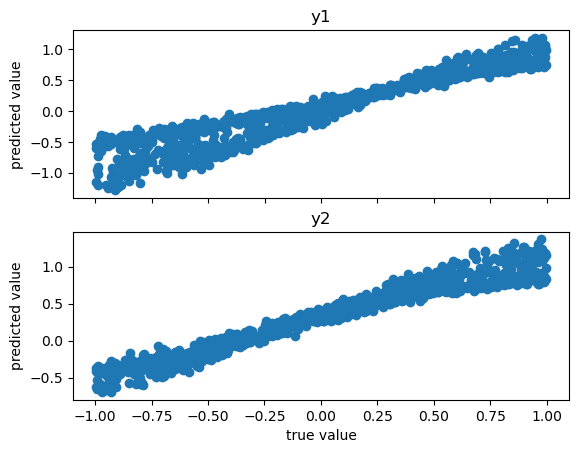

In [4]:
def prediction_accuracy(predictions, y1_validation, y2_validation): 
    y1 = predictions[0]
    y2 = predictions[1]
    fig, axs = plt.subplots(2)
    # fig.suptitle('')
    axs[0].scatter(y1_validation, y1)
    axs[0].set_title('y1')
    axs[1].scatter(y2_validation, y2)
    axs[1].set_title('y2')
    for ax in axs.flat:
        ax.set(xlabel='true value', ylabel='predicted value')
    for ax in axs.flat:
        ax.label_outer()

    print("rmse of y1: ", mean_squared_error(y1_validation, y1, squared=False))
    print("rmse of y2: ", mean_squared_error(y2_validation, y2, squared=False))

prediction_accuracy(predictions, y1_validation, y2_validation)

In [5]:
# data Augmentation
# Requires cleaning up

def rotation_matrix(angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    return R

def Augmentation_clock(x,y):

    x = x.copy()
    y = y.copy()
    # print(y)
    y_aug = np.transpose(np.matmul(rotation_matrix(-90), np.transpose(y)))
    # print(y_aug)

    temp = x.copy()
    x0 = temp[:,0]
    x1 = temp[:,1]
    x2 = temp[:,2]
    x3 = temp[:,3]

    # print(x0.shape)

    x[:,0] = x3
    x[:,1] = x0
    x[:,2] = x1
    x[:,3] = x2
 
    return x,y_aug


def Augmentation_flip(x,y):
    x = x.copy()
    y = y.copy()
    x = np.flip(x, axis=1)
    y[:,1] = -1 * y[:,1]
    return x,y

def Augmentation_anticlock(x,y):

    x = x.copy()
    y = y.copy()
    y_aug = np.transpose(np.matmul(rotation_matrix(90), np.transpose(y)))

    temp = x.copy()
    x0 = temp[:,0]
    x1 = temp[:,1]
    x2 = temp[:,2]
    x3 = temp[:,3]

    x[:,0] = x1
    x[:,1] = x2
    x[:,2] = x3
    x[:,3] = x0
 
    return x,y_aug

# # test inputs
# X_train = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
# # print(X_train)
# Y_train = np.array([[15,16], [17,18], [19,20]])
# num_rows, num_cols = X_train.shape

def data_augmentation(x,y):
    x_aug1,y_aug1 = Augmentation_clock(x, y)
    x_aug2,y_aug2 = Augmentation_clock(x_aug1,y_aug1)
    x_aug3,y_aug3 = Augmentation_clock(x_aug2,y_aug2)
    x_aug4,y_aug4 = Augmentation_flip(x_aug3,y_aug3)
    x_aug5,y_aug5 = Augmentation_clock(x_aug4,y_aug4)
    x_aug6,y_aug6 = Augmentation_clock(x_aug5,y_aug5)
    x_aug7,y_aug7 = Augmentation_clock(x_aug6,y_aug6)
    X_train_Aug = np.concatenate((X_train, x_aug1, x_aug2, x_aug3, x_aug4, x_aug5, x_aug6, x_aug7))
    Y_train_Aug = np.concatenate((Y_train, y_aug1, y_aug2, y_aug3, y_aug4, y_aug5, y_aug6, y_aug7))

    return X_train_Aug, Y_train_Aug

X_train_Aug, Y_train_Aug = data_augmentation(X_train, Y_train)
X_validation_Aug, Y_validation_Aug = data_augmentation(X_validation, Y_validation)

In [6]:
tf.random.set_seed(42) 

# Model trained on Augmented dataset
# Now we have one input layer, 1 hidden layer and 2 output layer - both connected to hidden layer
# Thinking of adding a normalization layer or doing normalization before training
# inputs = tf.keras.layers.Normalization(input_shape=[4,], axis=None)
inputs = tf.keras.Input(shape=(4,))
dense1 = tf.keras.layers.Dense(128, activation='relu')
# dense2_1 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y1')
# dense2_2 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y2')

dense2_1 = tf.keras.layers.Dense(1, name = 'y1')
dense2_2 = tf.keras.layers.Dense(1, name = 'y2')

x=dense1(inputs)

outputs1=dense2_1(x)
outputs2=dense2_2(x)

model = tf.keras.Model(inputs=inputs, outputs=[outputs1, outputs2], name = 'leakge_aug_functional_model')

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.mean_absolute_error,
              metrics = ['mae']
)

y = {
    "y1" : Y_train_Aug[:,0],
    "y2" : Y_train_Aug[:,1]
}

y_valid = {
    "y1" : Y_validation_Aug[:,0],
    "y2" : Y_validation_Aug[:,1]
}


model.fit(X_train_Aug, y=y, epochs=5, batch_size=5, verbose=2, validation_data=(X_validation_Aug, y_valid))

predictions = model.predict(X_validation_Aug)

# even for a primilinary result, the loss is pretty good

Model: "leakge_aug_functional_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 128)          640         ['input_2[0][0]']                
                                                                                                  
 y1 (Dense)                     (None, 1)            129         ['dense_1[0][0]']                
                                                                                                  
 y2 (Dense)                     (None, 1)            129         ['dense_1[0][0]']                
                                                                        

rmse of y1:  0.15609731613126046
rmse of y2:  0.17959691898169186


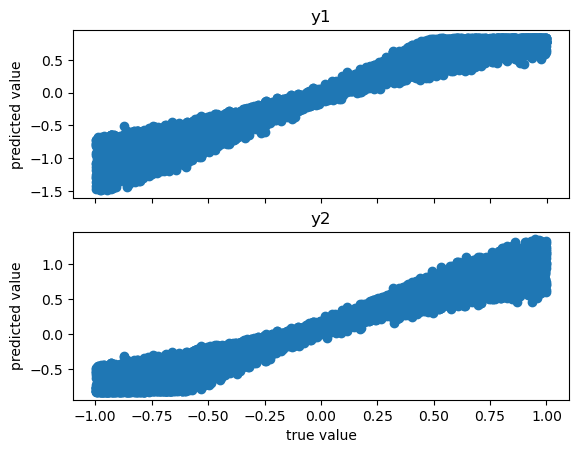

In [8]:
prediction_accuracy(predictions, Y_validation_Aug[:,0], Y_validation_Aug[:,1])

In [7]:
# failed experiment with Functional API

# from keras.models import Model
# from keras.layers import Dense, Input


# def base_model(inputs):
#     x= Dense(128, activation='relu')(inputs)
#     x= Dense(128, activation='relu')(x)
#     return x

# def final_model(inputs):
#     x = base_model(inputs)
#     y1 = Dense(units='1', name='y1')(x)
#     y2 = Dense(units = '1', name = 'y2')(x)
#     model = Model(inputs=inputs, outputs = [y1, y2])
    
#     return model

# inputs = tf.keras.layers.Input(shape=(4,))
# model = final_model(inputs)

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
#               loss=tf.keras.losses.mean_absolute_error,
#               metrics = ['mae'])
# y = {
#     "y1" : y1_train,
#     "y2" : y2_train
# }

# history = model.fit(X_train, y, epochs=400)